In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

%pip install -q git+https://github.com/espnet/espnet
%pip install -q espnet_model_zoo

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.

In [2]:
!pip install pydub pesq

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp310-cp310-linux_x86_64.whl size=224564 sha256=d7d374ac170d6e0fae233e9ecce30d455679f46d7ba344cc6c244c8e1bff11a0
  Stored in directory: /root/.cache/pip/wheels/c5/4e/2c/251524370c0fdd659e99639a0fbd0ca5a782c3aafcd456b28d
Successfully built pesq


## Choose Speech Enhancement model { run: "auto" }

In [3]:
fs = 16000 #@param {type:"integer"}
#"espnet/Wangyou_Zhang_chime4_enh_train_enh_conv_tasnet_raw" maybe OK for single-channel
tag = "espnet/Wangyou_Zhang_chime4_enh_train_enh_conv_tasnet_raw" #@param ["Yen-Ju Lu/dns_ins20_enh_train_enh_blstm_tf_raw_valid.loss.best", "lichenda/chime4_fasnet_dprnn_tac", "espnet/Wangyou_Zhang_chime4_enh_train_enh_conv_tasnet_raw", "Wangyou-Zhang/chime4_enh_train_enh_beamformer_mvdr_raw_valid.si_snr.ave"]

In [4]:
# For models uploaded to Zenodo, you can use the following python script instead:
import sys
import soundfile
from espnet_model_zoo.downloader import ModelDownloader
from espnet2.bin.enh_inference import SeparateSpeech

d = ModelDownloader()

cfg = d.download_and_unpack(tag)
enh_model_sc = SeparateSpeech(
  train_config=cfg["train_config"],
  model_file=cfg["model_file"],
  ref_channel=None,
  normalize_output_wav=True,
  device="cuda:0",
)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

## Upload audio for denoising

In [5]:
from pydub import AudioSegment

def resample_audio(audio_path, target_sr=16000):
  audio = AudioSegment.from_file(audio_path)
  resampled_audio = audio.set_frame_rate(target_sr)
  resampled_audio.export(audio_path, format='wav')

In [6]:
from google.colab import files
from IPython.display import display, Audio
import soundfile

uploaded = files.upload()

Saving 730-358-0037.wav to 730-358-0037.wav


In [7]:
file_keys = list(uploaded.keys())
file_keys

['730-358-0037.wav']

In [8]:
resample_audio(file_keys[0], target_sr=16000)

speech, rate = soundfile.read(file_keys[0]) # first file

assert rate == fs, "mismatch in sampling rate"
wave = enh_model_sc(speech[None, ...], fs)
print(f"Your input speech {file_keys[0]}", flush=True)
display(Audio(speech, rate=fs))
print(f"Enhanced speech for {file_keys[0]}", flush=True)
display(Audio(wave[0].squeeze(), rate=fs))

Your input speech 730-358-0037.wav


Enhanced speech for 730-358-0037.wav


In [9]:
# Save denoised file
# https://www.programcreek.com/python/example/95990/soundfile.write

soundfile.write(file_keys[0][:-4] + "_denoised.wav", wave[0].squeeze(), rate)

## Evaluate with y_test

In [10]:
y_test = files.upload()
file_keys_y_test = list(y_test.keys())

Saving 730-358-0037.wav to 730-358-0037 (1).wav


In [11]:
speech_clean, rate_clean = soundfile.read(file_keys_y_test[0]) # first file
print(f"Clean speech for {file_keys_y_test[0]}", flush=True)
display(Audio(speech_clean, rate=rate_clean))

Clean speech for 730-358-0037 (1).wav


In [12]:
from pydub import AudioSegment
import numpy as np
from pesq import pesq

def compute_sdr(noise_audio, clean_audio, enhanced_audio):
    noise_audio = np.array(noise_audio.get_array_of_samples())
    clean_audio = np.array(clean_audio.get_array_of_samples())
    enhanced_audio = np.array(enhanced_audio.get_array_of_samples())
    error_signal = noise_audio - clean_audio
    sdr = 10 * np.log10(np.sum(clean_audio ** 2) / np.sum(error_signal ** 2))
    return sdr

def compute_snr(noise_audio, clean_audio, enhanced_audio):
    clean_audio = np.array(clean_audio.get_array_of_samples())
    enhanced_audio = np.array(enhanced_audio.get_array_of_samples())
    noise_signal = clean_audio - enhanced_audio
    snr = 10 * np.log10(np.sum(clean_audio ** 2) / np.sum(noise_signal ** 2))
    return snr

# Load audio files
noise_audio = AudioSegment.from_file(file_keys[0], format="wav")
clean_audio = AudioSegment.from_file(file_keys_y_test[0], format="wav")
enhanced_audio = AudioSegment.from_file(file_keys[0][:-4] + "_denoised.wav", format="wav")

# Compute SDR and SNR
sdr = compute_sdr(noise_audio, clean_audio, enhanced_audio)
snr = compute_snr(noise_audio, clean_audio, enhanced_audio)

print("SDR:", sdr, "dB")
print("SNR:", snr, "dB")

# You can also compute PESQ (Perceptual Evaluation of Speech Quality) score using the pesq library
pesq_score = pesq(ref=np.array(clean_audio.get_array_of_samples()), deg=np.array(enhanced_audio.get_array_of_samples()), fs=clean_audio.frame_rate)
print("PESQ score:", pesq_score)

SDR: 1.460144781604043 dB
SNR: 2.091200495175473 dB
PESQ score: 1.1025214195251465


## Visualize waveforms

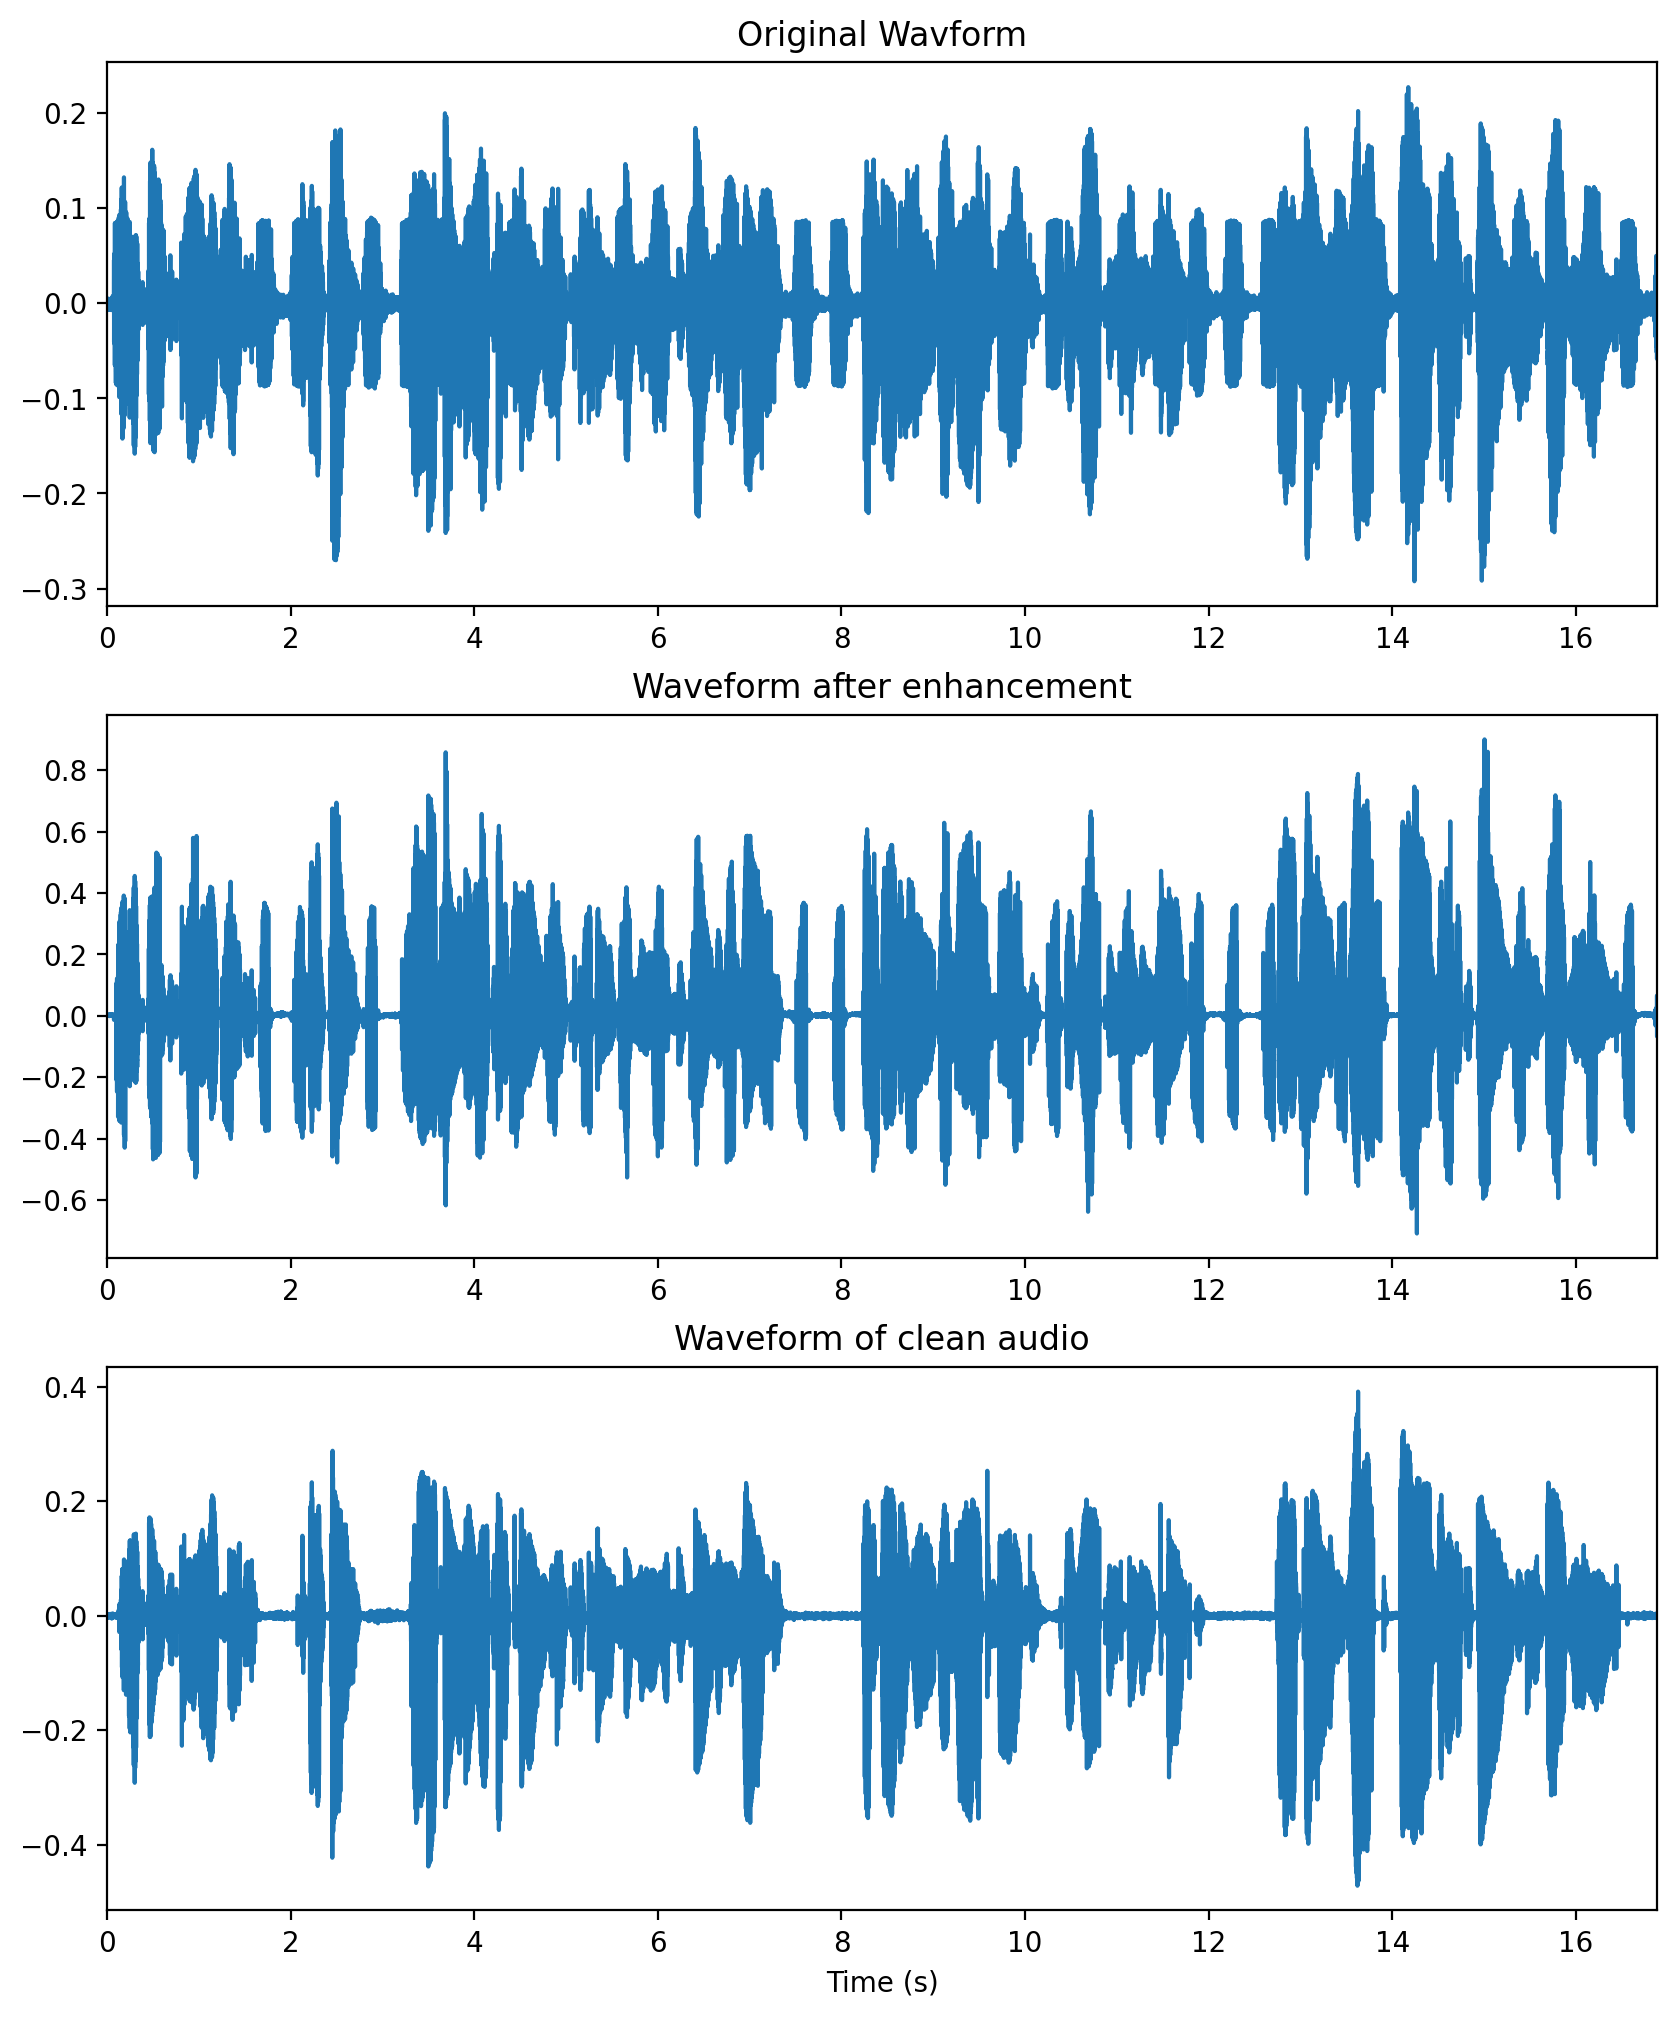

In [13]:
import matplotlib.pyplot as plt
import torch

plt.figure(figsize=(10, 12))

samples = torch.linspace(0, len(speech) / rate, len(speech))

plt.subplot(3, 1, 1)
plt.title('Original Wavform')
plt.plot(samples, speech)
plt.xlim(0, len(speech) / rate)

plt.subplot(3, 1, 2)
plt.title('Waveform after enhancement')
plt.plot(samples, wave[0].squeeze())
plt.xlim(0, len(speech) / rate)

plt.subplot(3, 1, 3)
plt.title('Waveform of clean audio')
plt.plot(samples, speech_clean)
plt.xlim(0, len(speech_clean) / rate)

plt.xlabel("Time (s)")
plt.show()